# Preprocess

In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# 读取数据
df = pd.read_csv('DeepLearning-Tutorial-Chinese/attendance_regression_detailedEDA_train/filtered_data_final.csv')

# 假设 df 是你的数据框
df.drop(columns=['id'], inplace=True)

# 将 num_broadcasters 列中的 '5+' 替换为 '5'，并转换为 int64 类型
df['num_broadcasters'] = df['num_broadcasters'].replace('5+', '5').astype(int)

# 将 match_datetime 列转换为 datetime 类型
df['match_datetime'] = pd.to_datetime(df['match_datetime'])

# 按 match_datetime 排序
df.sort_values('match_datetime', inplace=True)

# 提取时间特征
df['year'] = df['match_datetime'].dt.year
df['month'] = df['match_datetime'].dt.month
df['day'] = df['match_datetime'].dt.day
df['hour'] = df['match_datetime'].dt.hour

# 删除原始的 match_datetime 列
df.drop(columns=['match_datetime'], inplace=True)

# 定义特征和目标
X = df.drop(columns=['attendance'])
y = df['attendance']

# 对 X 进行缩放
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 将训练集和测试集转换为张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# 检查数据维度
print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 检查数据加载器
for X_batch, y_batch in train_loader:
    print(f'X_batch shape: {X_batch.shape}')
    print(f'y_batch shape: {y_batch.shape}')
    break  # 只检查第一个批次


X_train_tensor shape: torch.Size([2900, 1, 16])
y_train_tensor shape: torch.Size([2900])
X_test_tensor shape: torch.Size([726, 1, 16])
y_test_tensor shape: torch.Size([726])
X_batch shape: torch.Size([32, 1, 16])
y_batch shape: torch.Size([32])


# KAN Model

In [26]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features  # 输入特征数
        self.out_features = out_features  # 输出特征数
        self.grid_size = grid_size  # 网格大小
        self.spline_order = spline_order  # 样条阶数

        # 计算网格步长，并生成网格
        #         网格的作用
        # 定义B样条基函数的位置：

        # B样条基函数是在特定的支持点上进行计算的，这些支持点由网格确定。
        # 样条基函数在这些网格点上具有特定的值和形状。
        # 确定样条基函数的间隔：

        # 网格步长（h）决定了网格点之间的距离，从而影响样条基函数的平滑程度和覆盖范围。
        # 网格越密集，样条基函数的分辨率越高，可以更精细地拟合数据。
        # 构建用于插值和拟合的基础：

        # 样条基函数利用这些网格点进行插值，能够构建出连续的、平滑的函数。
        # 通过这些基函数，可以实现输入特征的复杂非线性变换。
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)  # 注册网格作为模型的buffer
        #         在PyTorch中，buffer是一种特殊类型的张量，它在模型中起到辅助作用，但不会作为模型参数进行更新。buffer通常用于存储一些在前向和后向传播过程中需要用到的常量或中间结果。buffer和模型参数一样，会被包含在模型的状态字典中（state dictionary），可以与模型一起保存和加载。

        # register_buffer 的作用
        # self.register_buffer("grid", grid) 的作用是将 grid 注册为模型的一个buffer。这样做有以下几个好处：

        # 持久化：buffer会被包含在模型的状态字典中，可以通过 state_dict 方法保存模型时一并保存，加载模型时也会一并恢复。这对于训练和推理阶段都很有用，确保所有相关的常量都能正确加载。

        # 无需梯度更新：buffer不会在反向传播过程中计算梯度和更新。它们是固定的，只在前向传播中使用。这对于像网格点这样的常量非常适合，因为这些点在训练过程中是固定的，不需要更新。

        # 易于使用：注册为 buffer 的张量可以像模型参数一样方便地访问和使用，而不必担心它们会被优化器错误地更新。

        # 初始化网络参数和超参数

        # 初始化基础权重参数，形状为 (out_features, in_features)
        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        # 初始化样条权重参数，形状为 (out_features, in_features, grid_size + spline_order)
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )

        # 如果启用了独立缩放样条功能，初始化样条缩放参数，形状为 (out_features, in_features)
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        # 噪声缩放系数，用于初始化样条权重时添加噪声
        self.scale_noise = scale_noise

        # 基础权重的缩放系数，用于初始化基础权重时的缩放因子
        self.scale_base = scale_base

        # 样条权重的缩放系数，用于初始化样条权重时的缩放因子
        self.scale_spline = scale_spline

        # 是否启用独立的样条缩放功能
        self.enable_standalone_scale_spline = enable_standalone_scale_spline

        # 基础激活函数实例，用于对输入进行非线性变换
        self.base_activation = base_activation()

        # 网格更新时的小偏移量，用于在更新网格时引入微小变化，避免过拟合
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        # 使用kaiming_uniform_方法初始化基础权重参数base_weight
        # 这个方法基于何凯明初始化，适用于具有ReLU等非线性激活函数的网络
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        
        with torch.no_grad():
            # 为样条权重参数spline_weight添加噪声进行初始化
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            
            # 计算样条权重参数的初始值，结合了scale_spline的缩放因子
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                # 作者此前使用了一般的初始化，效果不佳
                # 使用kaiming_uniform_方法初始化样条缩放参数spline_scaler
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)


    def b_splines(self, x: torch.Tensor):
        """
        计算给定输入张量的B样条基函数。
        B样条（B-splines）是一种用于函数逼近和插值的基函数。
        它们具有局部性、平滑性和数值稳定性等优点，广泛应用于计算机图形学、数据拟合和机器学习中。
        在这段代码中，B样条基函数用于在输入张量上进行非线性变换，以提高模型的表达能力。
        在KAN（Kolmogorov-Arnold Networks）模型中，B样条基函数用于将输入特征映射到高维空间中，以便在该空间中进行线性变换。
        具体来说，B样条基函数能够在给定的网格点上对输入数据进行插值和逼近，从而实现复杂的非线性变换。

        参数:
            x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。

        返回:
            torch.Tensor: B样条基函数张量，形状为 (batch_size, in_features, grid_size + spline_order)。
        """
        # 确保输入张量的维度是2，并且其列数等于输入特征数
        assert x.dim() == 2 and x.size(1) == self.in_features

        # 获取网格点（包含在buffer中的self.grid）
        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)

        # 为了进行逐元素操作，将输入张量的最后一维扩展一维
        x = x.unsqueeze(-1)

        # 初始化B样条基函数的基矩阵
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        
        # 迭代计算样条基函数
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        # 确保B样条基函数的输出形状正确
        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()


    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        计算插值给定点的曲线的系数。
        curve2coeff 方法用于计算插值给定点的曲线的系数。
        这些系数用于表示插值曲线在特定点的形状和位置。
        具体来说，该方法通过求解线性方程组来找到B样条基函数在给定点上的插值系数。
        此方法的作用是根据输入和输出点计算B样条基函数的系数，
        使得这些基函数能够精确插值给定的输入输出点对。
        这样可以用于拟合数据或在模型中应用非线性变换。
        
        参数:
            x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
            y (torch.Tensor): 输出张量，形状为 (batch_size, in_features, out_features)。

        返回:
            torch.Tensor: 系数张量，形状为 (out_features, in_features, grid_size + spline_order)。
        """
        # 确保输入张量的维度是2，并且其列数等于输入特征数
        assert x.dim() == 2 and x.size(1) == self.in_features
        
        # 确保输出张量的形状正确
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        # 计算B样条基函数
        A = self.b_splines(x).transpose(0, 1)  # (in_features, batch_size, grid_size + spline_order)
        
        # 转置输出张量
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        
        # 使用线性代数方法求解线性方程组，找到系数
        solution = torch.linalg.lstsq(A, B).solution  # (in_features, grid_size + spline_order, out_features)
        
        # 调整结果的形状
        result = solution.permute(2, 0, 1)  # (out_features, in_features, grid_size + spline_order)

        # 确保结果张量的形状正确
        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        
        # 返回连续存储的结果张量
        return result.contiguous()


    @property
    def scaled_spline_weight(self):
        """
        计算带有缩放因子的样条权重。

        样条缩放：如果启用了 enable_standalone_scale_spline，
        则将 spline_scaler 张量扩展一维后与 spline_weight 相乘，
        否则直接返回 spline_weight。

        具体来说，spline_weight 是一个三维张量，形状为 (out_features, in_features, grid_size + spline_order)。
        而 spline_scaler 是一个二维张量，形状为 (out_features, in_features)。
        为了使 spline_scaler 能够与 spline_weight 逐元素相乘，
        需要将 spline_scaler 的最后一维扩展，以匹配 spline_weight 的第三维。

        返回:
            torch.Tensor: 带有缩放因子的样条权重张量。
        """
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )


    def forward(self, x: torch.Tensor):
        """
        实现模型的前向传播。

        参数:
            x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。

        返回:
            torch.Tensor: 输出张量，形状为 (batch_size, out_features)。
        """
        # 确保输入张量的最后一维大小等于输入特征数
        assert x.size(-1) == self.in_features
        
        # 保存输入张量的原始形状
        original_shape = x.shape
        
        # 将输入张量展平为二维
        x = x.view(-1, self.in_features)

        # 计算基础线性变换的输出
        base_output = F.linear(self.base_activation(x), self.base_weight)
        
        # 计算B样条基函数的输出
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        
        # 合并基础输出和样条输出
        output = base_output + spline_output
        
        # 恢复输出张量的形状
        output = output.view(*original_shape[:-1], self.out_features)
        
        return output


    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        """
        update_grid 方法用于根据输入数据动态更新B样条的网格点，从而适应输入数据的分布。
        该方法通过重新计算和调整网格点，确保B样条基函数能够更好地拟合数据。
        这在训练过程中可能会提高模型的精度和稳定性。

        参数:
            x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
            margin (float): 网格更新的边缘大小，用于在更新网格时引入微小变化。
        """
        # 确保输入张量的维度正确
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)  # 获取批量大小

        # 计算输入张量的B样条基函数
        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # 转置为 (in, batch, coeff)

        # 获取当前的样条权重
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # 转置为 (in, coeff, out)

        # 计算未缩减的样条输出
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)  # 转置为 (batch, in, out)

        # 为了收集数据分布，对每个通道分别进行排序
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        # 计算均匀步长，并生成均匀网格
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        # 混合均匀网格和自适应网格
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive

        # 扩展网格以包括样条边界
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        # 更新模型中的网格点
        self.grid.copy_(grid.T)

        # 重新计算样条权重
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))


    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        计算正则化损失。

        这是对论文中提到的原始L1正则化的一种简单模拟，因为原始方法需要从
        展开的 (batch, in_features, out_features) 中间张量计算绝对值和熵，
        但如果我们想要一个高效的内存实现，这些张量会被隐藏在F.linear函数后面。

        现在的L1正则化计算为样条权重的平均绝对值。
        作者的实现还包括这个项，此外还有基于样本的正则化。
        """
        # 计算样条权重的绝对值的平均值
        l1_fake = self.spline_weight.abs().mean(-1)
        
        # 计算激活正则化损失，即所有样条权重绝对值的和
        regularization_loss_activation = l1_fake.sum()
        
        # 计算每个权重占总和的比例
        p = l1_fake / regularization_loss_activation
        
        # 计算熵正则化损失，即上述比例的负熵
        regularization_loss_entropy = -torch.sum(p * p.log())
        
        # 返回总的正则化损失，包含激活正则化和熵正则化
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


########################################################## 类定义
class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        """
        初始化KAN模型。

        参数:
            layers_hidden (list): 每层的输入和输出特征数列表。
            grid_size (int): 网格大小。
            spline_order (int): 样条阶数。
            scale_noise (float): 样条权重初始化时的噪声缩放系数。
            scale_base (float): 基础权重初始化时的缩放系数。
            scale_spline (float): 样条权重初始化时的缩放系数。
            base_activation (nn.Module): 基础激活函数类。
            grid_eps (float): 网格更新时的小偏移量。
            grid_range (list): 网格范围。
        """
        super(KAN, self).__init__()
        self.grid_size = grid_size  # 网格大小
        self.spline_order = spline_order  # 样条阶数

        # 初始化模型层
        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        """
        实现模型的前向传播。

        参数:
            x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
            update_grid (bool): 是否在前向传播过程中更新网格。

        返回:
            torch.Tensor: 输出张量，形状为 (batch_size, out_features)。
        """
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        计算模型的正则化损失。

        参数:
            regularize_activation (float): 激活正则化系数。
            regularize_entropy (float): 熵正则化系数。

        返回:
            float: 总的正则化损失。
        """
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# Set Model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_features = 16
output_features = 1
# 隐藏层特征数
hidden_features = [32, 64, 32]

# 构建KAN模型
kan_model = KAN(
    layers_hidden=[input_features] + hidden_features + [output_features],
    grid_size=5,
    spline_order=3,
    scale_noise=0.1,
    scale_base=1.0,
    scale_spline=1.0,
    base_activation=torch.nn.SiLU,
    grid_eps=0.02,
    grid_range=[-1, 1],
)

# 打印模型结构
print(kan_model)

# 创建一个随机输入张量进行测试
input_dim = 16  # 假设输入特征的维度为 16
batch_size = 32  # 假设批量大小为 32
test_input = torch.randn(batch_size, input_dim)

# 将输入通过模型进行前向传播
with torch.no_grad():
    test_output = kan_model(test_input)

# 打印输入和输出的形状
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")



KAN(
  (layers): ModuleList(
    (0-3): 4 x KANLinear(
      (base_activation): SiLU()
    )
  )
)
Input shape: torch.Size([32, 16])
Output shape: torch.Size([32, 1])


# RMSELoss

Epoch 1/200, Train Loss: 20124.0743, Val Loss: 20074.0780, Train R²: -3.6376, Val R²: -3.6285
Epoch 2/200, Train Loss: 16800.4833, Val Loss: 10467.7014, Train R²: -2.3178, Val R²: -0.2904
Epoch 3/200, Train Loss: 9048.5616, Val Loss: 8587.3742, Train R²: 0.0249, Val R²: 0.1307
Epoch 4/200, Train Loss: 8213.3630, Val Loss: 7644.0596, Train R²: 0.2091, Val R²: 0.3115
Epoch 5/200, Train Loss: 7124.6488, Val Loss: 6589.1555, Train R²: 0.3998, Val R²: 0.4889
Epoch 6/200, Train Loss: 6448.1164, Val Loss: 6275.9479, Train R²: 0.5112, Val R²: 0.5371
Epoch 7/200, Train Loss: 6286.0807, Val Loss: 6239.5915, Train R²: 0.5374, Val R²: 0.5430
Epoch 8/200, Train Loss: 6250.6888, Val Loss: 6218.3629, Train R²: 0.5405, Val R²: 0.5462
Epoch 9/200, Train Loss: 6184.1070, Val Loss: 6143.1233, Train R²: 0.5499, Val R²: 0.5574
Epoch 10/200, Train Loss: 6132.6537, Val Loss: 6117.0150, Train R²: 0.5580, Val R²: 0.5610
Epoch 11/200, Train Loss: 6154.8979, Val Loss: 6104.9633, Train R²: 0.5589, Val R²: 0.5630


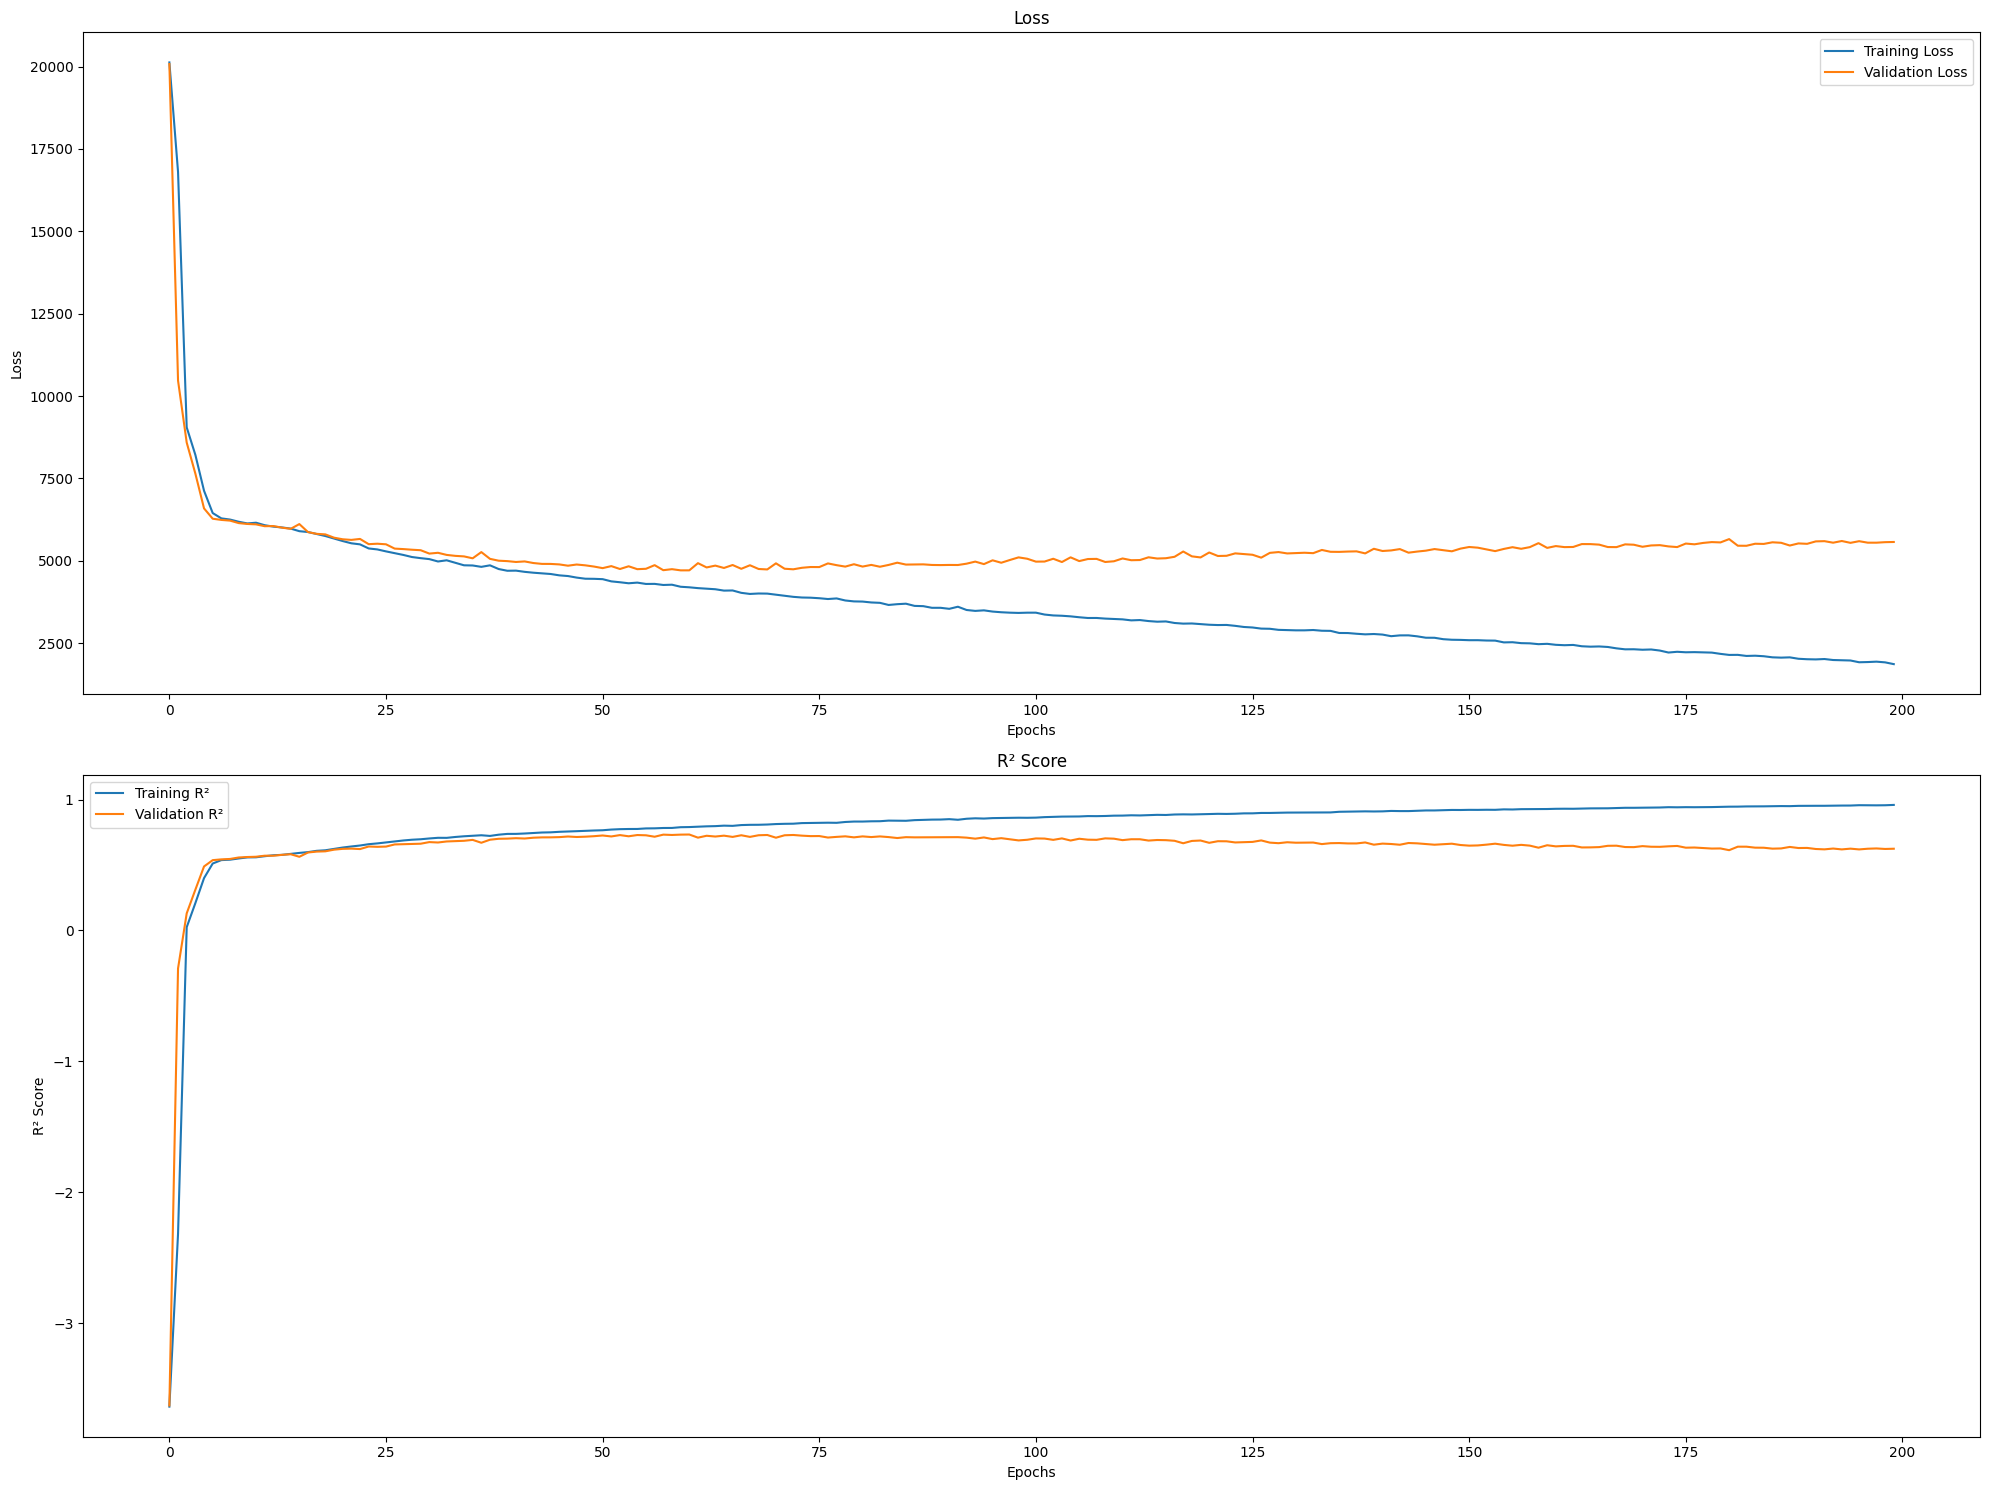

In [28]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import csv

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# 初始化模型、损失函数和优化器
input_dim = X_train_tensor.shape[2]
model = KAN(
            layers_hidden=[input_dim, 64, 128, 64, 1],
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        ).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 200
train_losses = []
val_losses = []
val_r2_scores = []
train_r2_scores = []

# 打开一个 CSV 文件以记录损失和 R² 值
with open('rmse.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training R²', 'Validation R²'])

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_targets_all = []
        train_outputs_all = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), targets.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            # 确保目标的形状与输出匹配
            targets = targets.unsqueeze(-1)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            train_targets_all.extend(targets.cpu().detach().numpy())
            train_outputs_all.extend(outputs.cpu().detach().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        train_r2 = r2_score(np.array(train_targets_all).reshape(-1, 1), np.array(train_outputs_all).reshape(-1, 1))
        train_r2_scores.append(train_r2)

        model.eval()
        val_running_loss = 0.0
        y_preds = []
        y_true = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), targets.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(inputs).squeeze(-1)
                
                # 确保目标的形状与输出匹配
                targets = targets.unsqueeze(-1)
                
                val_loss = criterion(outputs, targets)
                val_running_loss += val_loss.item() * inputs.size(0)
                
                y_preds.extend(outputs.cpu().detach().numpy())
                y_true.extend(targets.cpu().detach().numpy())

        val_loss = val_running_loss / len(test_loader.dataset)
        val_losses.append(val_loss)

        y_preds = np.array(y_preds).reshape(-1, 1)
        y_true = np.array(y_true).reshape(-1, 1)
        
        val_r2 = r2_score(y_true, y_preds)
        val_r2_scores.append(val_r2)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}')
        
        # 将当前epoch的损失和R²值记录到CSV文件中
        writer.writerow([epoch + 1, train_loss, val_loss, train_r2, val_r2])

# 绘制训练损失和验证 R²
plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_r2_scores, label='Training R²')
plt.plot(val_r2_scores, label='Validation R²')
plt.title('R² Score')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.show()


# HuberLoss

Epoch 1/200, Train Loss: 17933.1967, Val Loss: 17870.9224, Train R²: -3.6413, Val R²: -3.6419
Epoch 2/200, Train Loss: 14141.3607, Val Loss: 7150.6834, Train R²: -2.3754, Val R²: -0.3348
Epoch 3/200, Train Loss: 6484.3335, Val Loss: 6147.5897, Train R²: -0.0531, Val R²: 0.0576
Epoch 4/200, Train Loss: 5843.3573, Val Loss: 5481.5468, Train R²: 0.1255, Val R²: 0.2175
Epoch 5/200, Train Loss: 5130.3415, Val Loss: 4839.5089, Train R²: 0.3278, Val R²: 0.4015
Epoch 6/200, Train Loss: 4734.0321, Val Loss: 4624.6231, Train R²: 0.4461, Val R²: 0.4834
Epoch 7/200, Train Loss: 4631.5753, Val Loss: 4562.7750, Train R²: 0.4862, Val R²: 0.5106
Epoch 8/200, Train Loss: 4599.7965, Val Loss: 4542.8997, Train R²: 0.5056, Val R²: 0.5204
Epoch 9/200, Train Loss: 4604.1964, Val Loss: 4579.2530, Train R²: 0.5050, Val R²: 0.5293
Epoch 10/200, Train Loss: 4579.2478, Val Loss: 4519.0736, Train R²: 0.5144, Val R²: 0.5285
Epoch 11/200, Train Loss: 4561.8019, Val Loss: 4508.6519, Train R²: 0.5185, Val R²: 0.5359


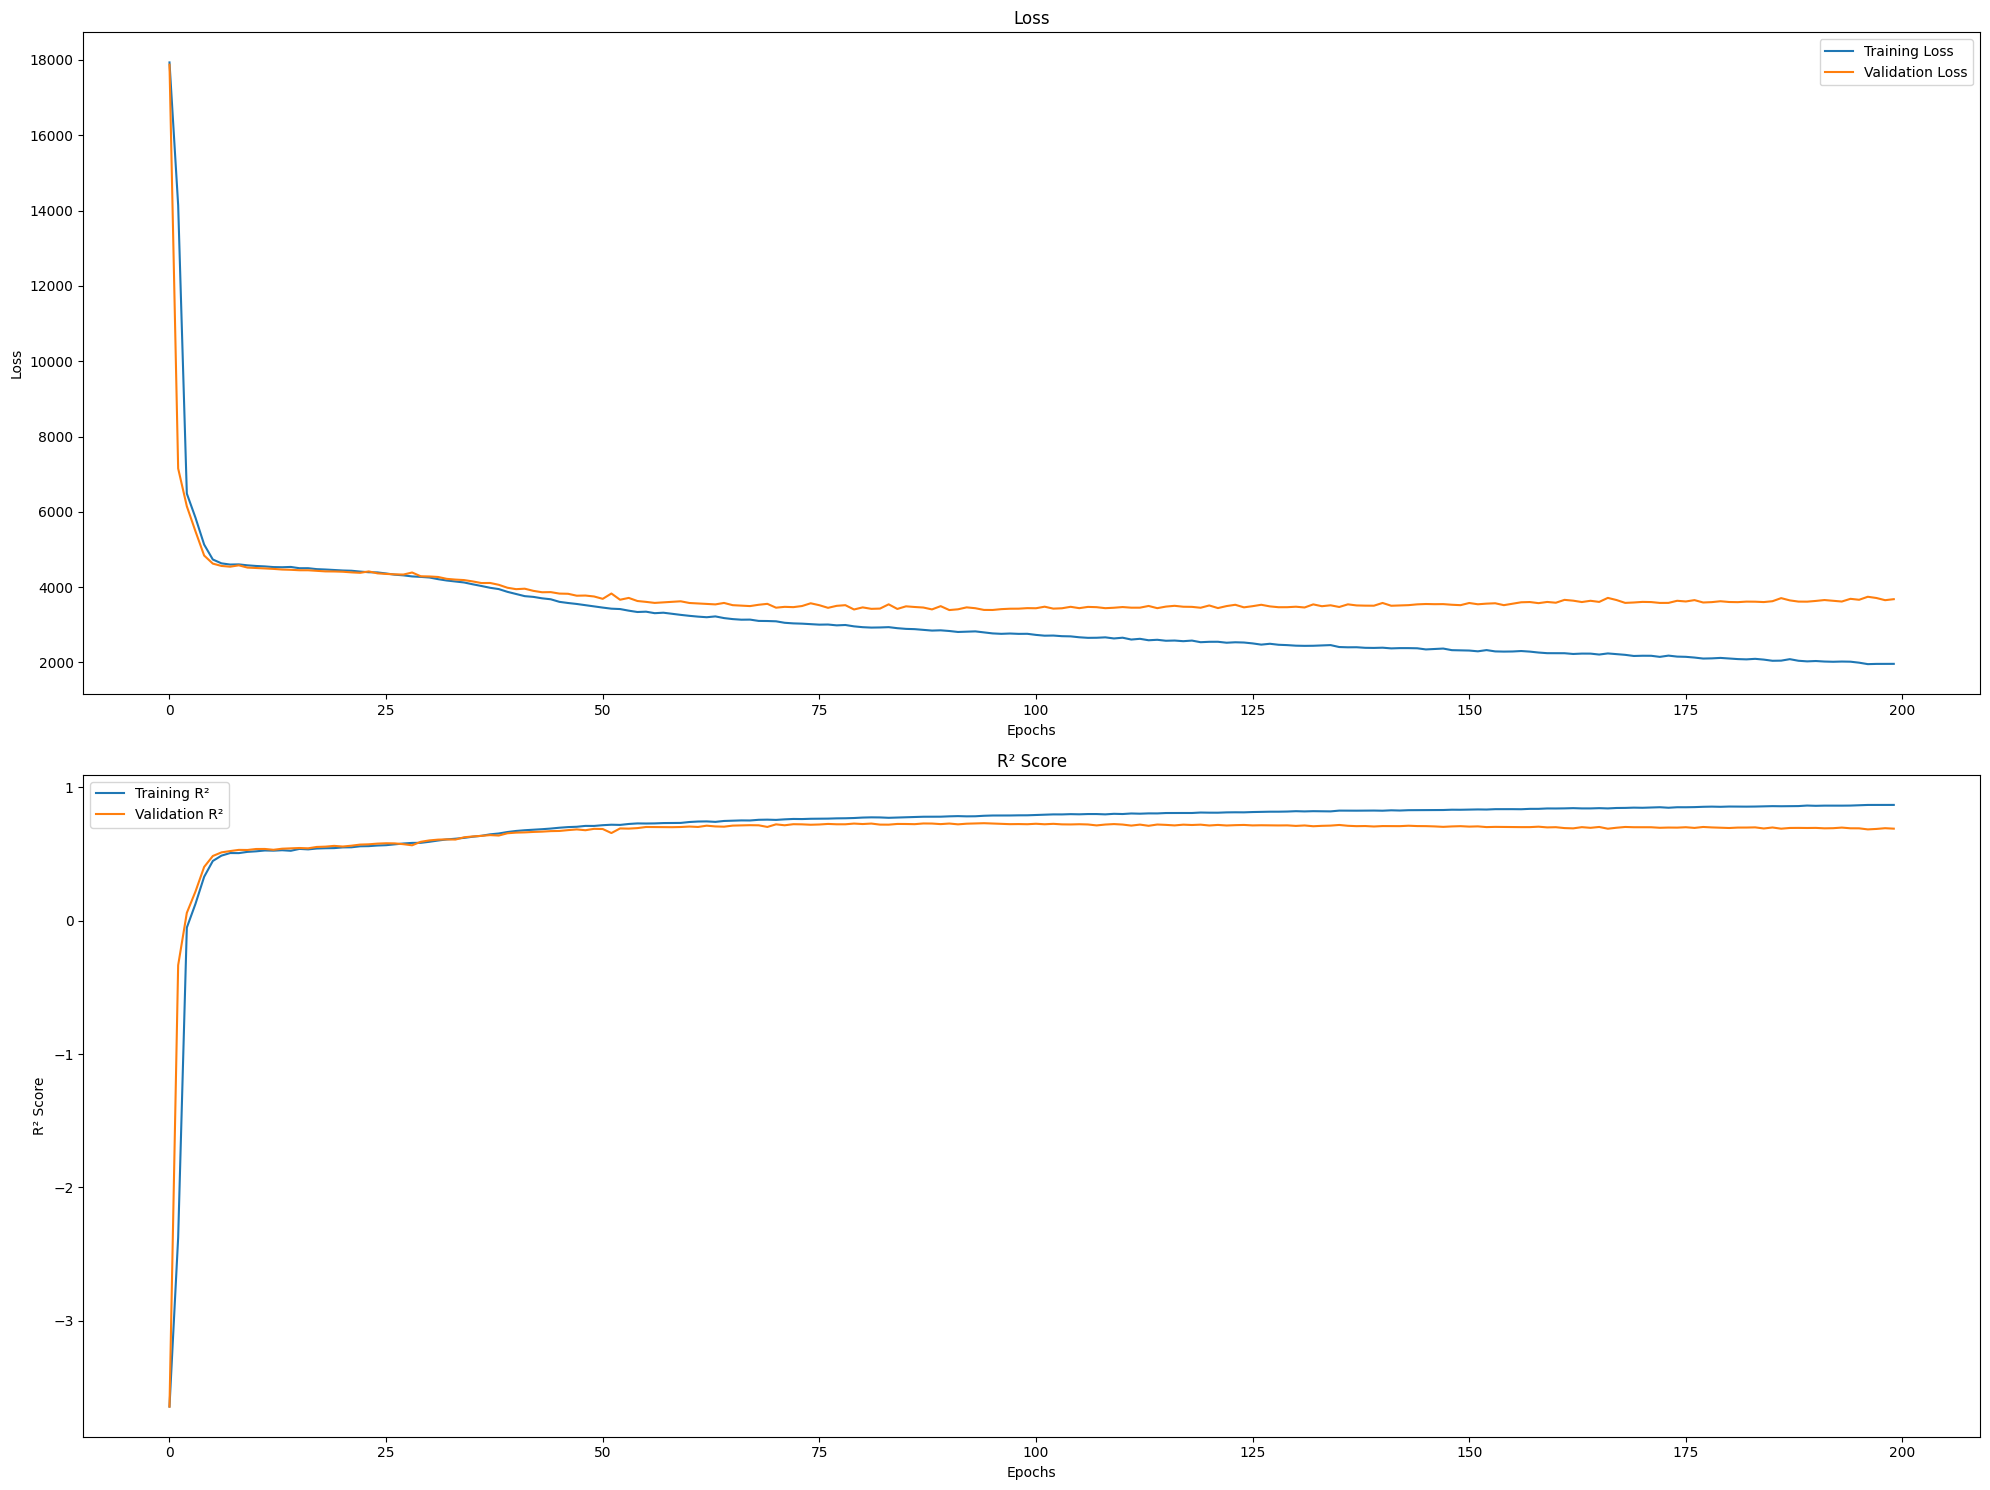

In [29]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import csv

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# 初始化模型、损失函数和优化器
input_dim = X_train_tensor.shape[2]
model = KAN(
            layers_hidden=[input_dim, 64, 128, 64, 1],
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        ).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 200
train_losses = []
val_losses = []
val_r2_scores = []
train_r2_scores = []

# 打开一个 CSV 文件以记录损失和 R² 值
with open('huber.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training R²', 'Validation R²'])

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_targets_all = []
        train_outputs_all = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), targets.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            # 确保目标的形状与输出匹配
            targets = targets.unsqueeze(-1)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            train_targets_all.extend(targets.cpu().detach().numpy())
            train_outputs_all.extend(outputs.cpu().detach().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        train_r2 = r2_score(np.array(train_targets_all).reshape(-1, 1), np.array(train_outputs_all).reshape(-1, 1))
        train_r2_scores.append(train_r2)

        model.eval()
        val_running_loss = 0.0
        y_preds = []
        y_true = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), targets.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(inputs).squeeze(-1)
                
                # 确保目标的形状与输出匹配
                targets = targets.unsqueeze(-1)
                
                val_loss = criterion(outputs, targets)
                val_running_loss += val_loss.item() * inputs.size(0)
                
                y_preds.extend(outputs.cpu().detach().numpy())
                y_true.extend(targets.cpu().detach().numpy())

        val_loss = val_running_loss / len(test_loader.dataset)
        val_losses.append(val_loss)

        y_preds = np.array(y_preds).reshape(-1, 1)
        y_true = np.array(y_true).reshape(-1, 1)
        
        val_r2 = r2_score(y_true, y_preds)
        val_r2_scores.append(val_r2)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}')
        
        # 将当前epoch的损失和R²值记录到CSV文件中
        writer.writerow([epoch + 1, train_loss, val_loss, train_r2, val_r2])

# 绘制训练损失和验证 R²
plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_r2_scores, label='Training R²')
plt.plot(val_r2_scores, label='Validation R²')
plt.title('R² Score')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.show()



# MSELoss

Epoch 1/200, Train Loss: 409422620.5131, Val Loss: 403916765.6198, Train R²: -3.6353, Val R²: -3.6063
Epoch 2/200, Train Loss: 282936623.6359, Val Loss: 106361815.2948, Train R²: -2.2033, Val R²: -0.2130
Epoch 3/200, Train Loss: 86720065.3683, Val Loss: 76685334.8540, Train R²: 0.0182, Val R²: 0.1255
Epoch 4/200, Train Loss: 71077301.0207, Val Loss: 61435470.9862, Train R²: 0.1953, Val R²: 0.2994
Epoch 5/200, Train Loss: 55750691.3297, Val Loss: 47967204.7603, Train R²: 0.3688, Val R²: 0.4530
Epoch 6/200, Train Loss: 45208235.6579, Val Loss: 41462758.0055, Train R²: 0.4882, Val R²: 0.5272
Epoch 7/200, Train Loss: 41544485.9366, Val Loss: 40060666.8540, Train R²: 0.5296, Val R²: 0.5431
Epoch 8/200, Train Loss: 40583988.8607, Val Loss: 39429149.2672, Train R²: 0.5405, Val R²: 0.5503
Epoch 9/200, Train Loss: 40152470.0745, Val Loss: 39712094.6667, Train R²: 0.5454, Val R²: 0.5471
Epoch 10/200, Train Loss: 39790338.5600, Val Loss: 38772902.1928, Train R²: 0.5495, Val R²: 0.5578
Epoch 11/20

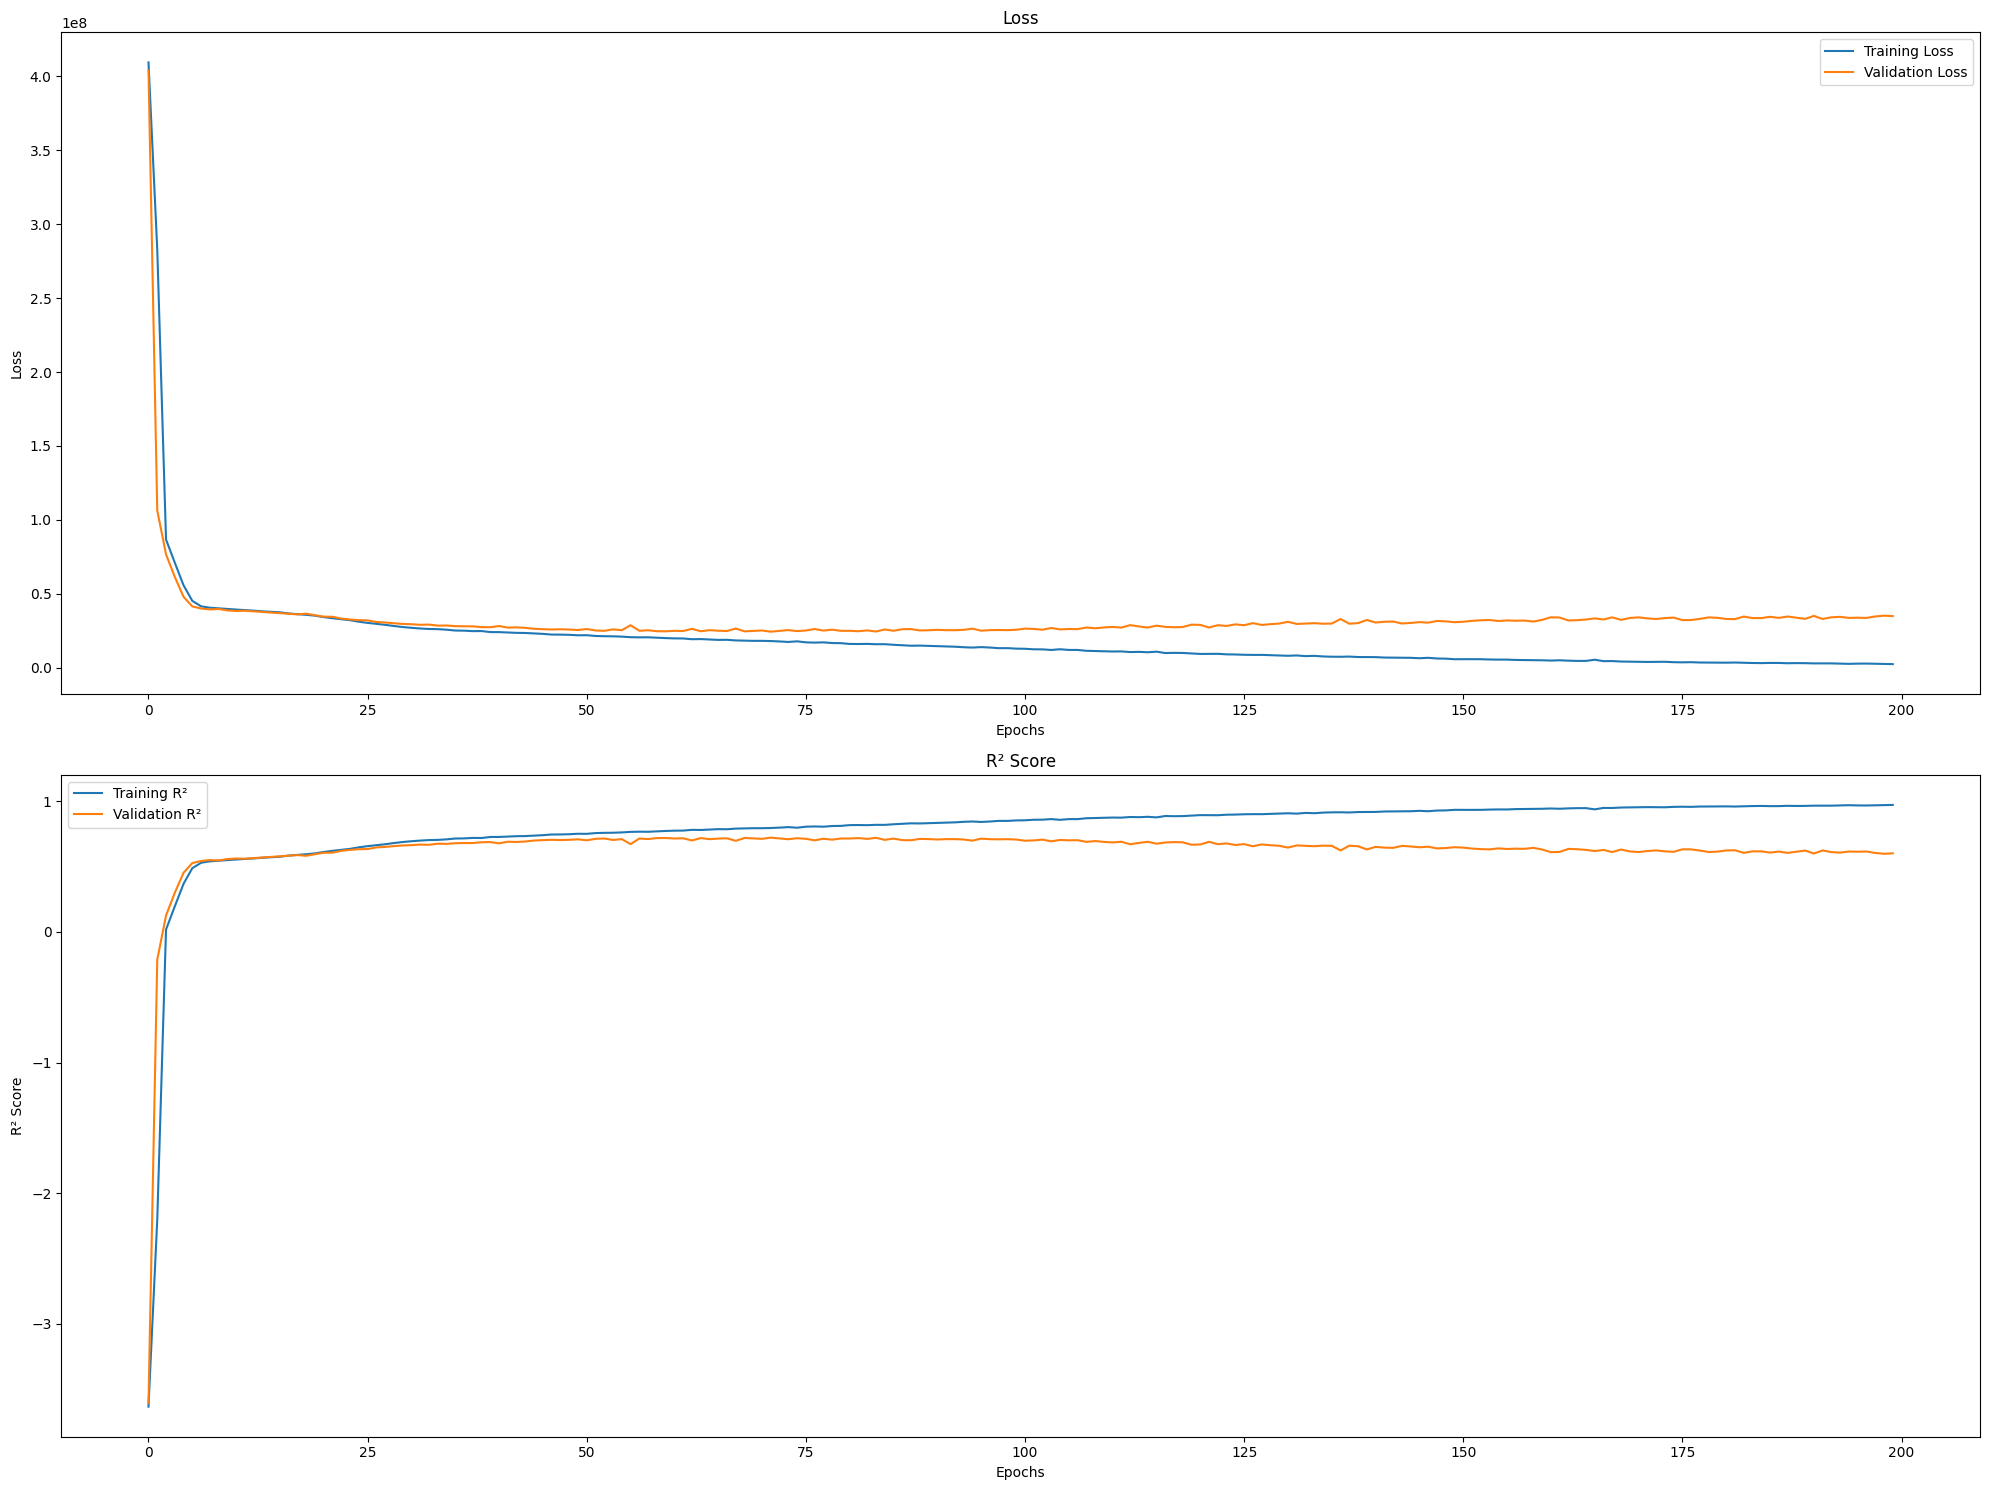

In [30]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import csv

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# 初始化模型、损失函数和优化器
input_dim = X_train_tensor.shape[2]
model = KAN(
            layers_hidden=[input_dim, 64, 128, 64, 1],
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        ).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 200
train_losses = []
val_losses = []
val_r2_scores = []
train_r2_scores = []

# 打开一个 CSV 文件以记录损失和 R² 值
with open('baseline.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training R²', 'Validation R²'])

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_targets_all = []
        train_outputs_all = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), targets.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            # 确保目标的形状与输出匹配
            targets = targets.unsqueeze(-1)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            train_targets_all.extend(targets.cpu().detach().numpy())
            train_outputs_all.extend(outputs.cpu().detach().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        train_r2 = r2_score(np.array(train_targets_all).reshape(-1, 1), np.array(train_outputs_all).reshape(-1, 1))
        train_r2_scores.append(train_r2)

        model.eval()
        val_running_loss = 0.0
        y_preds = []
        y_true = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), targets.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(inputs).squeeze(-1)
                
                # 确保目标的形状与输出匹配
                targets = targets.unsqueeze(-1)
                
                val_loss = criterion(outputs, targets)
                val_running_loss += val_loss.item() * inputs.size(0)
                
                y_preds.extend(outputs.cpu().detach().numpy())
                y_true.extend(targets.cpu().detach().numpy())

        val_loss = val_running_loss / len(test_loader.dataset)
        val_losses.append(val_loss)

        y_preds = np.array(y_preds).reshape(-1, 1)
        y_true = np.array(y_true).reshape(-1, 1)
        
        val_r2 = r2_score(y_true, y_preds)
        val_r2_scores.append(val_r2)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}')
        
        # 将当前epoch的损失和R²值记录到CSV文件中
        writer.writerow([epoch + 1, train_loss, val_loss, train_r2, val_r2])

# 绘制训练损失和验证 R²
plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_r2_scores, label='Training R²')
plt.plot(val_r2_scores, label='Validation R²')
plt.title('R² Score')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.show()



# Comparison

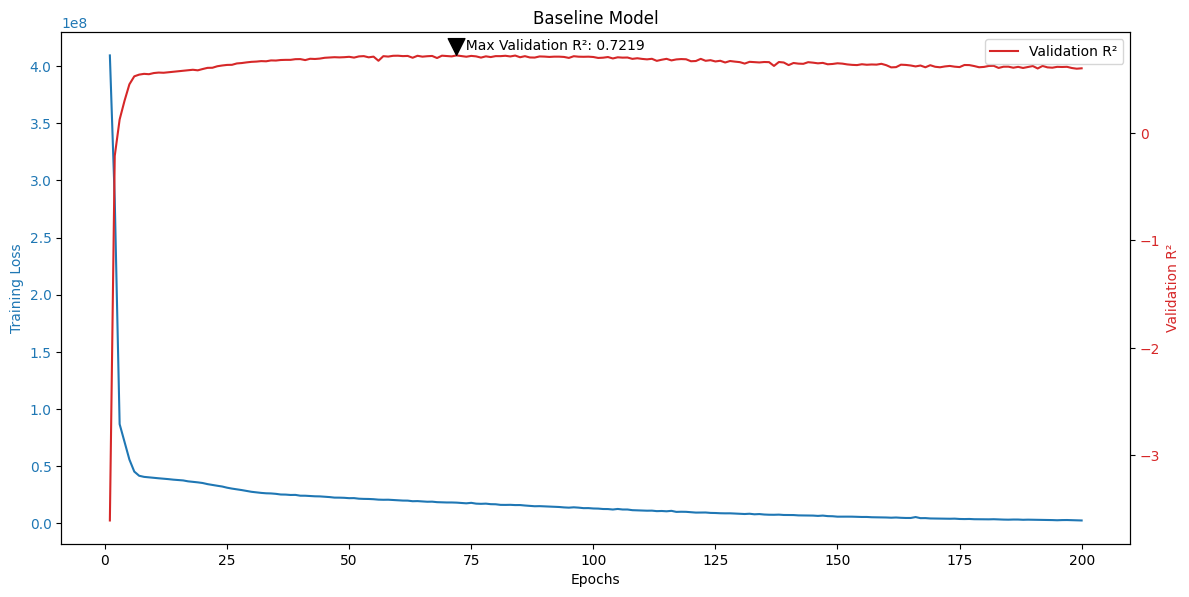

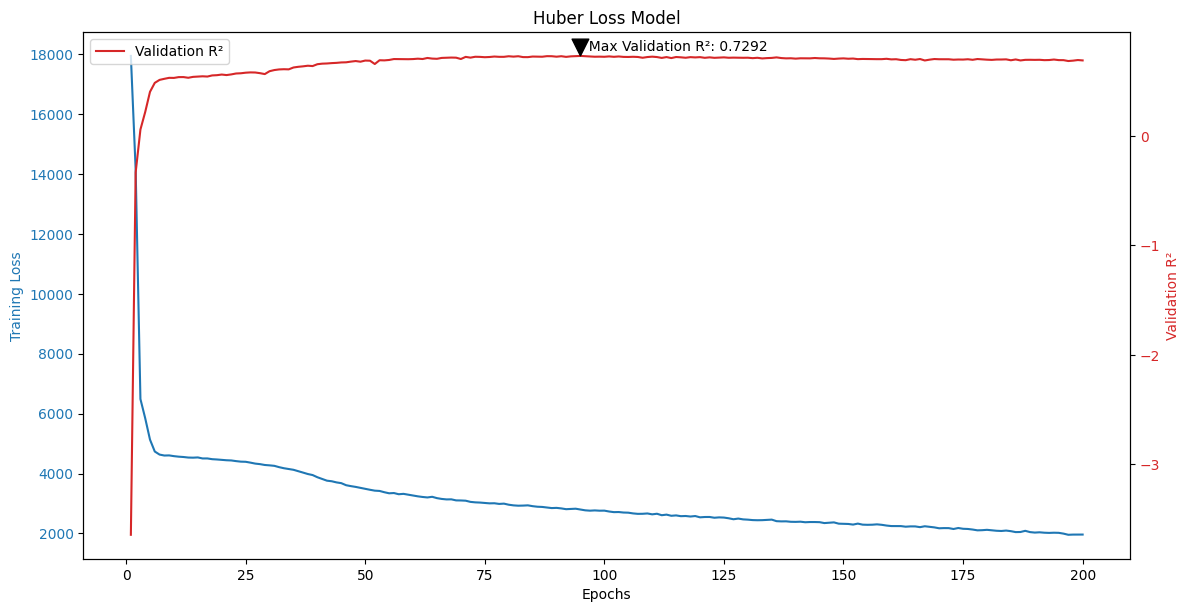

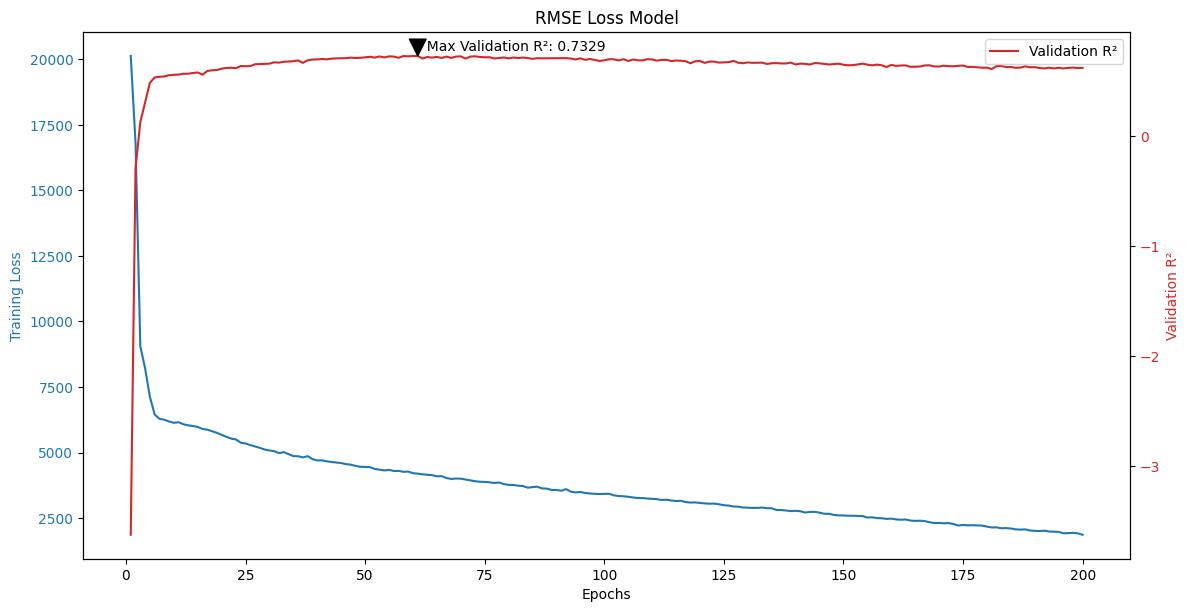

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取CSV文件
baseline_data = pd.read_csv('/teamspace/studios/this_studio/baseline.csv')
huber_data = pd.read_csv('/teamspace/studios/this_studio/huber.csv')
rmse_data = pd.read_csv('/teamspace/studios/this_studio/rmse.csv')

# 定义绘图函数
def plot_with_annotation(data, title, y1_label, y2_label):
    epochs = data['Epoch']
    y1 = data[y1_label]
    y2 = data[y2_label]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(epochs, y1, color=color, label=y1_label)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(epochs, y2, color=color, label=y2_label)
    ax2.tick_params(axis='y', labelcolor=color)

    # 标注最高点
    max_y2 = np.max(y2)
    max_epoch = epochs[np.argmax(y2)]
    ax2.annotate(f'  Max {y2_label}: {max_y2:.4f}', xy=(max_epoch, max_y2), xytext=(max_epoch, max_y2 + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.legend()
    plt.show()

# 绘制图形
plot_with_annotation(baseline_data, 'Baseline Model', 'Training Loss', 'Validation R²')
plot_with_annotation(huber_data, 'Huber Loss Model', 'Training Loss', 'Validation R²')
plot_with_annotation(rmse_data, 'RMSE Loss Model', 'Training Loss', 'Validation R²')


# Detail Comparison

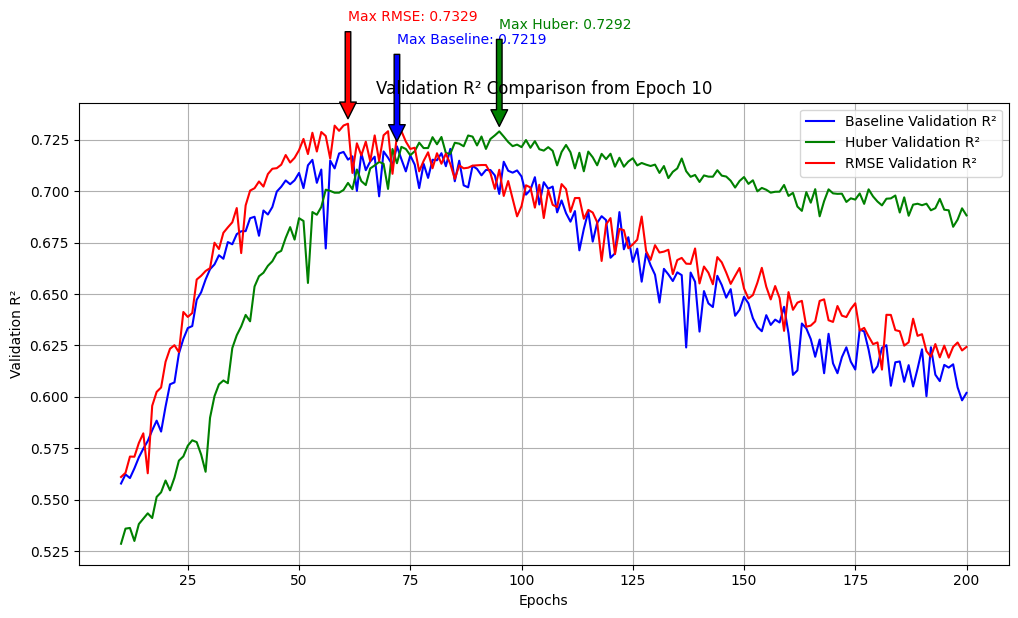

In [36]:
# 读取CSV文件
baseline_data = pd.read_csv('/teamspace/studios/this_studio/baseline.csv')
huber_data = pd.read_csv('/teamspace/studios/this_studio/huber.csv')
rmse_data = pd.read_csv('/teamspace/studios/this_studio/rmse.csv')

# 只保留第10轮及以后的数据
baseline_data = baseline_data[baseline_data['Epoch'] >= 10]
huber_data = huber_data[huber_data['Epoch'] >= 10]
rmse_data = rmse_data[rmse_data['Epoch'] >= 10]

# 绘制图形
plt.figure(figsize=(12, 6))

plt.plot(baseline_data['Epoch'], baseline_data['Validation R²'], label='Baseline Validation R²', color='blue')
plt.plot(huber_data['Epoch'], huber_data['Validation R²'], label='Huber Validation R²', color='green')
plt.plot(rmse_data['Epoch'], rmse_data['Validation R²'], label='RMSE Validation R²', color='red')

# 标注Baseline最高点
max_baseline_val_r2 = baseline_data['Validation R²'].max()
max_baseline_epoch = baseline_data['Epoch'][baseline_data['Validation R²'].idxmax()]
plt.annotate(f'Max Baseline: {max_baseline_val_r2:.4f}', xy=(max_baseline_epoch, max_baseline_val_r2), xytext=(max_baseline_epoch, max_baseline_val_r2 + 0.05),
             arrowprops=dict(facecolor='blue', shrink=0.05), color='blue')

# 标注Huber最高点
max_huber_val_r2 = huber_data['Validation R²'].max()
max_huber_epoch = huber_data['Epoch'][huber_data['Validation R²'].idxmax()]
plt.annotate(f'Max Huber: {max_huber_val_r2:.4f}', xy=(max_huber_epoch, max_huber_val_r2), xytext=(max_huber_epoch, max_huber_val_r2 + 0.05),
             arrowprops=dict(facecolor='green', shrink=0.05), color='green')

# 标注RMSE最高点
max_rmse_val_r2 = rmse_data['Validation R²'].max()
max_rmse_epoch = rmse_data['Epoch'][rmse_data['Validation R²'].idxmax()]
plt.annotate(f'Max RMSE: {max_rmse_val_r2:.4f}', xy=(max_rmse_epoch, max_rmse_val_r2), xytext=(max_rmse_epoch, max_rmse_val_r2 + 0.05),
             arrowprops=dict(facecolor='red', shrink=0.05), color='red')

plt.xlabel('Epochs')
plt.ylabel('Validation R²')
plt.title('Validation R² Comparison from Epoch 10')
plt.legend()
plt.grid(True)
plt.show()
